**Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


**Loading the Dataset**

In [ ]:
stroke_data_table = pd.read_csv('healthcare-dataset-stroke-data.csv')  # Loading data to pandas format

# **Data and information visualization**

The beginning of the data: 

      id  gender   age  hypertension  heart_disease ever_married      work_type Residence_type  avg_glucose_level   bmi   smoking_status  stroke
0   9046    Male  67.0             0              1          Yes        Private          Urban             228.69  36.6  formerly smoked       1
1  51676  Female  61.0             0              0          Yes  Self-employed          Rural             202.21   NaN     never smoked       1
2  31112    Male  80.0             0              1          Yes        Private          Rural             105.92  32.5     never smoked       1
3  60182  Female  49.0             0              0          Yes        Private          Urban             171.23  34.4           smokes       1
4   1665  Female  79.0             1              0          Yes  Self-employed          Rural             174.12  24.0     never smoked       1
Description of the data table: 


                 id          age  hypertension  heart_disease  avg_

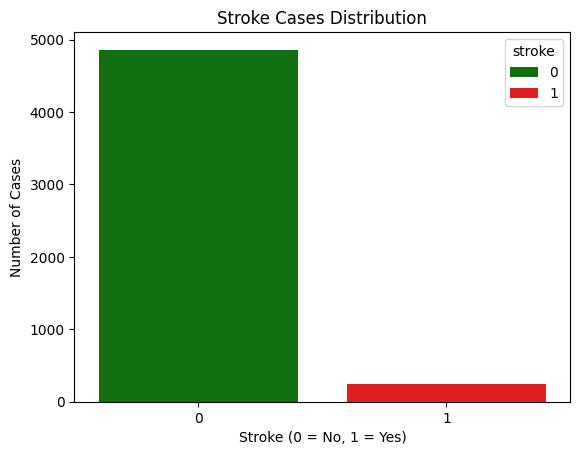

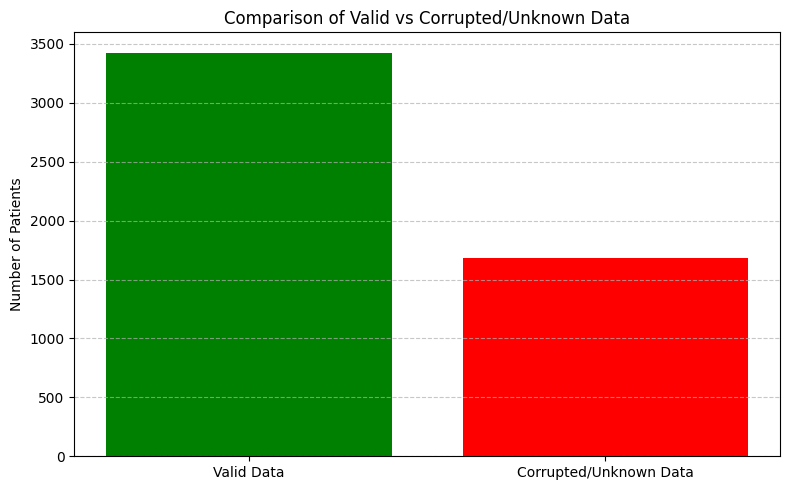

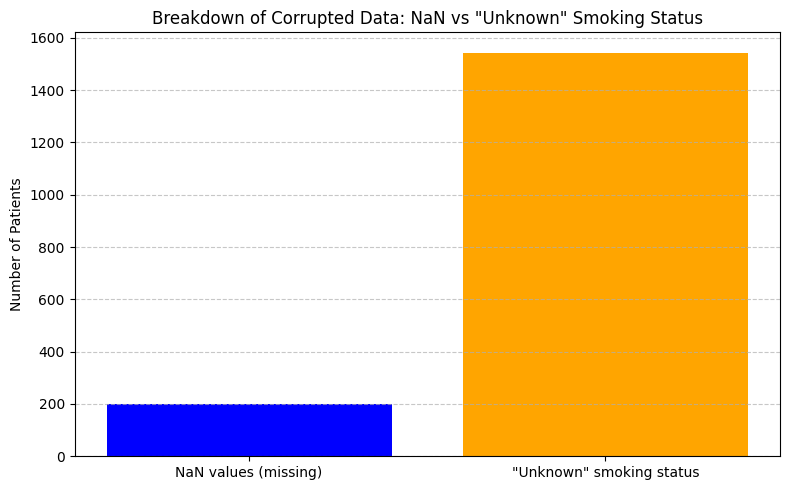


BMI Missing Data Analysis:

Number of rows with missing BMI: 201
Number of rows with BMI present: 4909


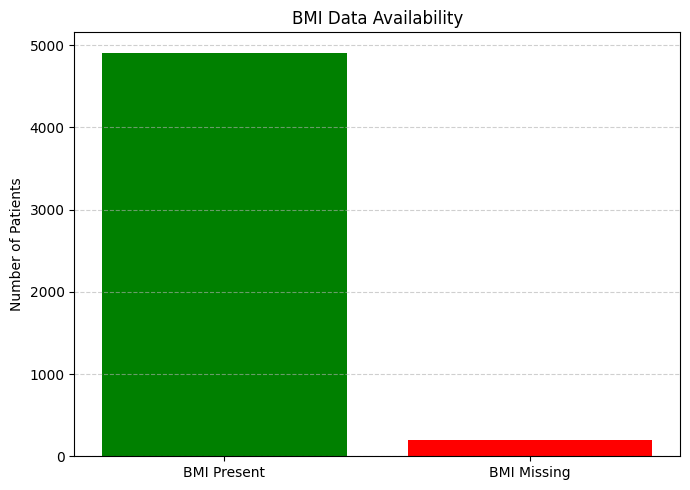




Stroke count across ages: 





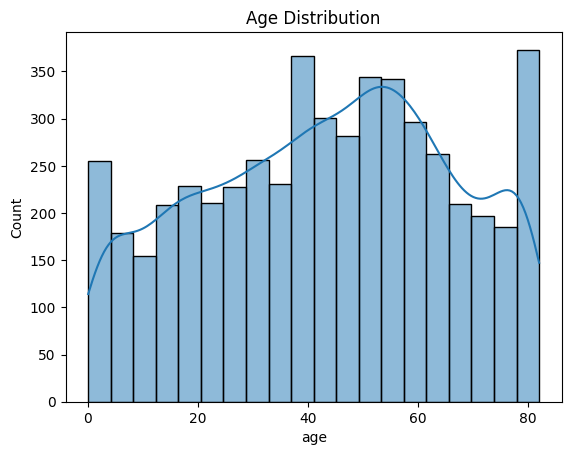

In [ ]:
# Fixing display lenghts for proper data showcasing
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

print("The beginning of the data: \n")
print(stroke_data_table.head()) # ShowCase the beginning of the data table

print("Description of the data table: \n\n")
print(stroke_data_table.describe())

# Count of stroke cases
stroke_counts = stroke_data_table['stroke'].value_counts()

print("\n\n\nStroke Case Summary (in data-set):\n")
print(f"Number of stroke-free cases (stroke = 0): {stroke_counts.get(0, 0)}")
print(f"Number of stroke cases (stroke = 1): {stroke_counts.get(1, 0)}")

# Visualize
# Define custom color palette: 0 → green, 1 → red
countplot_colors = {0: 'green', 1: 'red'}

# Plot
sns.countplot(data=stroke_data_table, x='stroke', hue='stroke', palette=countplot_colors)
plt.title("Stroke Cases Distribution")
plt.xlabel("Stroke (0 = No, 1 = Yes)")
plt.ylabel("Number of Cases")
plt.show()

# Identify corrupted data
is_missing = stroke_data_table.isnull().any(axis=1)
is_unknown_smoking = stroke_data_table['smoking_status'] == 'Unknown'
corrupted_rows = is_missing | is_unknown_smoking

# Count corrupted and valid rows
num_corrupted = corrupted_rows.sum()
num_valid = len(stroke_data_table) - num_corrupted

print() # added \n

# --- Plot 1: Valid vs Corrupted ---
labels1 = ['Valid Data', 'Corrupted/Unknown Data']
counts1 = [num_valid, num_corrupted]
colors1 = ['green', 'red']

plt.figure(figsize=(8, 5))
plt.bar(labels1, counts1, color=colors1)
plt.title('Comparison of Valid vs Corrupted/Unknown Data')
plt.ylabel('Number of Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2: Breakdown of Corrupted Data (NaN vs Unknown) ---
print() # added \n
num_nan_rows = is_missing.sum()
num_unknown_smoking = is_unknown_smoking.sum()

labels2 = ['NaN values (missing)', '"Unknown" smoking status']
counts2 = [num_nan_rows, num_unknown_smoking]
colors2 = ['blue', 'orange']

plt.figure(figsize=(8, 5))
plt.bar(labels2, counts2, color=colors2)
plt.title('Breakdown of Corrupted Data: NaN vs "Unknown" Smoking Status')
plt.ylabel('Number of Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nBMI Missing Data Analysis:\n")

# Check which rows have missing BMI
missing_bmi_mask = stroke_data_table['bmi'].isna()
num_missing_bmi = missing_bmi_mask.sum()
num_present_bmi = len(stroke_data_table) - num_missing_bmi

print(f"Number of rows with missing BMI: {num_missing_bmi}")
print(f"Number of rows with BMI present: {num_present_bmi}")

# Create labels and counts
labels = ['BMI Present', 'BMI Missing']
counts = [num_present_bmi, num_missing_bmi]
colors = ['green', 'red']

# Plot
plt.figure(figsize=(7, 5))
plt.bar(labels, counts, color=colors)
plt.title('BMI Data Availability')
plt.ylabel('Number of Patients')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n\n\nStroke count across ages: \n\n\n")
sns.histplot(stroke_data_table['age'], kde=True)
plt.title("Age Distribution")
plt.show()


# **Preprocessing**

In [ ]:
# Load data
df = stroke_data_table.copy()

# Replace 'Unknown' with NaN in smoking_status
df['smoking_status'] = df['smoking_status'].replace('Unknown', pd.NA)

# Fill missing values in numeric columns
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Fill missing binary columns before mapping
df['ever_married'] = df['ever_married'].fillna(df['ever_married'].mode()[0])
df['Residence_type'] = df['Residence_type'].fillna(df['Residence_type'].mode()[0])

# Map binary columns
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})

# Fill unknowns in smoking_status and encode categoricals
df['smoking_status'] = df['smoking_status'].fillna('Unknown')
df = pd.get_dummies(df, columns=['gender', 'work_type', 'smoking_status'], drop_first=True)

# Split features and target
X = df.drop('stroke', axis=1)
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Just in case: Fill remaining missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = X_test.fillna(X_test.median(numeric_only=True))

# Align test set to training set's columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Store all processed data in a single dictionary
data_after_preprocessing = {
    'original_training_features': X_train,                # Original training features (before SMOTE)
    'original_test_features': X_test,                     # Test features
    'original_training_lables': y_train,                  # Original training labels (before SMOTE)
    'labels_test': y_test,                                # Test labels
    'modified_balanced_training_features': X_train_resampled,         # Balanced training features (after SMOTE)
    'modified_balanced_lables': y_train_resampled            # Balanced training labels (after SMOTE)
}


# Data after preprocessing:

                                NaN Count  Unknown Count
id                                   1022              0
age                                  1022              0
hypertension                         1022              0
heart_disease                        1022              0
ever_married                         1022              0
Residence_type                       1022              0
avg_glucose_level                    1022              0
bmi                                  1022              0
gender_Male                          1022              0
gender_Other                         1022              0
work_type_Never_worked               1022              0
work_type_Private                    1022              0
work_type_Self-employed              1022              0
work_type_children                   1022              0
smoking_status_formerly smoked       1022              0
smoking_status_never smoked          1022              0
smoking_status_smokes          

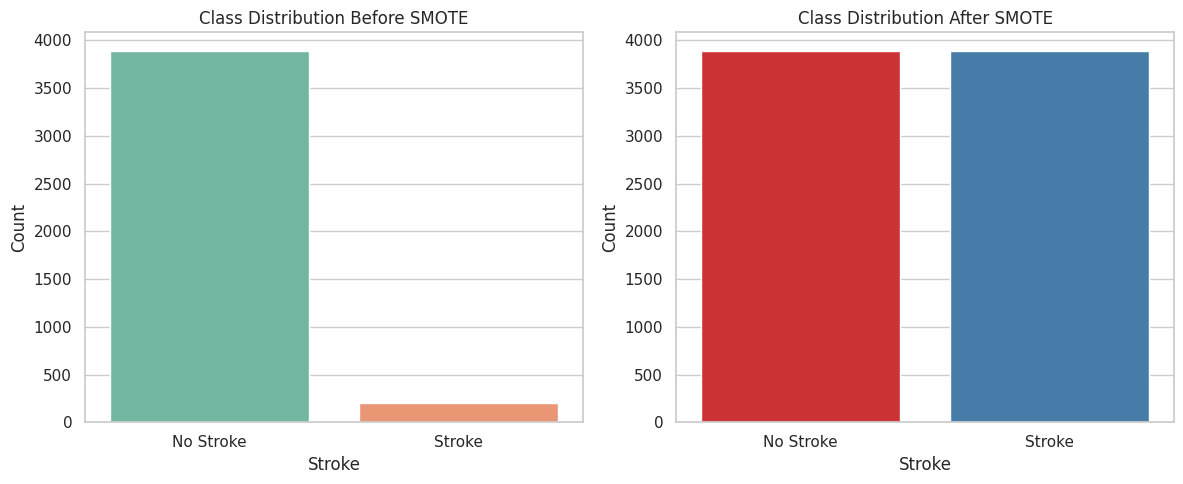

In [ ]:
# Combine all X/y DataFrames into one DataFrame for missing value analysis
combined_df = pd.concat([
    data_after_preprocessing['original_training_features'],
    data_after_preprocessing['original_test_features'],
    data_after_preprocessing['original_training_lables'],
    data_after_preprocessing['labels_test']
], axis=1)

# Count NaN values per column
null_counts = combined_df.isna().sum()

# Count 'Unknown' string values per column
unknown_counts = combined_df.apply(
    lambda col: (col == 'Unknown').sum() if col.dtypes == 'object' else 0
)

# Combine the two into a single DataFrame
missing_info = pd.DataFrame({
    'NaN Count': null_counts,
    'Unknown Count': unknown_counts
})

print(missing_info)

# Plot class distributions before and after SMOTE
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=data_after_preprocessing['original_training_lables'],
              hue=data_after_preprocessing['original_training_lables'],
              palette="Set2", ax=axes[0], legend=False)
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Stroke")
axes[0].set_ylabel("Count")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Stroke', 'Stroke'])

# After SMOTE
sns.countplot(x=data_after_preprocessing['modified_balanced_lables'],
              hue=data_after_preprocessing['modified_balanced_lables'],
              palette="Set1", ax=axes[1], legend=False)
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Stroke")
axes[1].set_ylabel("Count")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No Stroke', 'Stroke'])

plt.tight_layout()
plt.show()

# **Training & Evaluation of Multiple Models**

--- Random Forest ---
Accuracy : 0.913894324853229
Precision: 0.14814814814814814
Recall   : 0.16
F1 Score : 0.15384615384615385

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.15      0.16      0.15        50

    accuracy                           0.91      1022
   macro avg       0.55      0.56      0.55      1022
weighted avg       0.92      0.91      0.92      1022



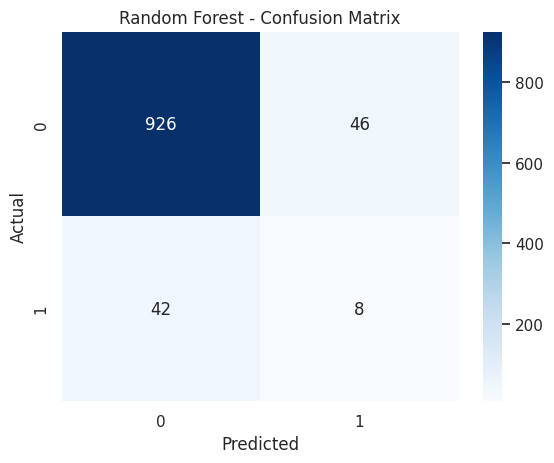

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost ---
Accuracy : 0.9119373776908023
Precision: 0.1
Recall   : 0.1
F1 Score : 0.1

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       972
           1       0.10      0.10      0.10        50

    accuracy                           0.91      1022
   macro avg       0.53      0.53      0.53      1022
weighted avg       0.91      0.91      0.91      1022



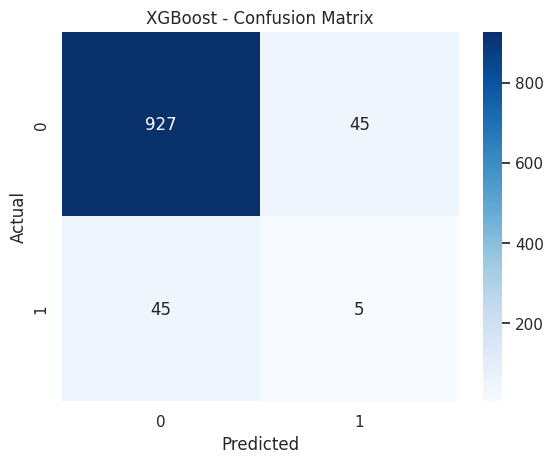

In [ ]:
# Define function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    print(f"--- {model_name} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. Random Forest
rf_model = RandomForestClassifier(random_state=12)
rf_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])
evaluate_model(rf_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "Random Forest")

# 2. XGBoost
xgb_model = XGBClassifier(random_state=12, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])
evaluate_model(xgb_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "XGBoost")

--- Random Forest (Threshold = 0.4) ---
Accuracy : 0.8767123287671232
Precision: 0.12
Recall   : 0.24
F1 Score : 0.16

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       972
           1       0.12      0.24      0.16        50

    accuracy                           0.88      1022
   macro avg       0.54      0.57      0.55      1022
weighted avg       0.92      0.88      0.90      1022



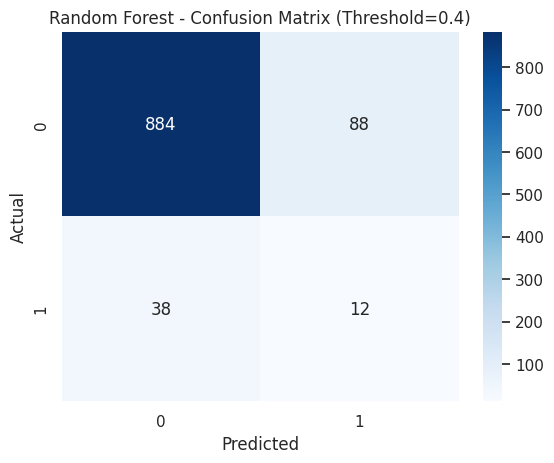

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:10:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost (Threshold = 0.4) ---
Accuracy : 0.9021526418786693
Precision: 0.109375
Recall   : 0.14
F1 Score : 0.12280701754385964

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.11      0.14      0.12        50

    accuracy                           0.90      1022
   macro avg       0.53      0.54      0.54      1022
weighted avg       0.91      0.90      0.91      1022



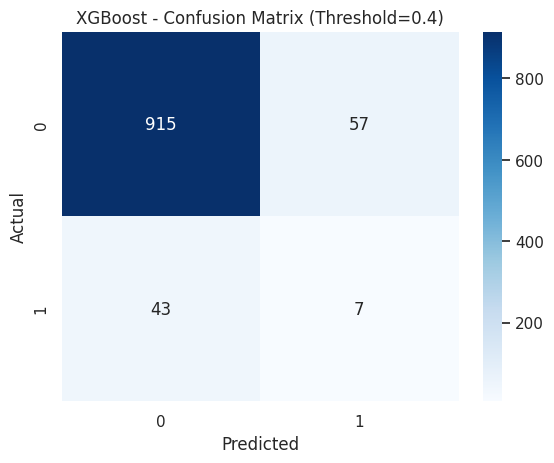

In [ ]:
def evaluate_model_with_threshold(model, X_test, y_test, model_name, threshold=0.6):
    # Get probabilities for class 1
    y_probs = model.predict_proba(X_test)[:, 1]

    # Apply threshold
    y_pred = (y_probs >= threshold).astype(int)

    print(f"--- {model_name} (Threshold = {threshold}) ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix (Threshold={threshold})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. Random Forest
rf_model = RandomForestClassifier(random_state=12)
rf_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])
evaluate_model_with_threshold(rf_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "Random Forest", threshold=0.4)

# 2. XGBoost
xgb_model = XGBClassifier(random_state=12, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])
evaluate_model_with_threshold(xgb_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "XGBoost", threshold=0.4)

Best Threshold = 0.26 (F1 = 0.21)

--- Random Forest (Threshold = 0.26) ---
Accuracy : 0.7876712328767124
Precision: 0.1288888888888889
Recall   : 0.58
F1 Score : 0.2109090909090909

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.13      0.58      0.21        50

    accuracy                           0.79      1022
   macro avg       0.55      0.69      0.54      1022
weighted avg       0.93      0.79      0.84      1022



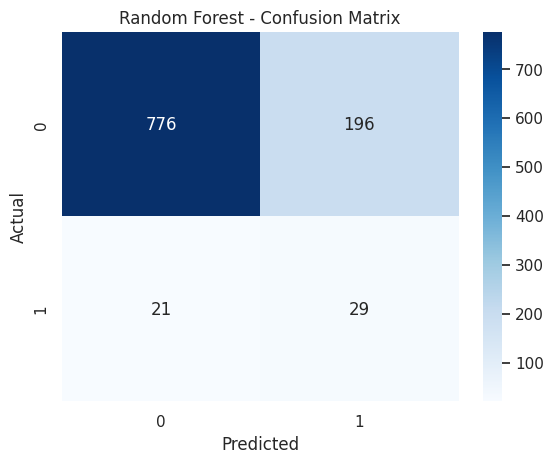

Best Threshold = 0.03 (F1 = 0.21)

--- XGBoost (Threshold = 0.030402524396777153) ---
Accuracy : 0.7534246575342466
Precision: 0.12313432835820895
Recall   : 0.66
F1 Score : 0.20754716981132076

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.85       972
           1       0.12      0.66      0.21        50

    accuracy                           0.75      1022
   macro avg       0.55      0.71      0.53      1022
weighted avg       0.94      0.75      0.82      1022



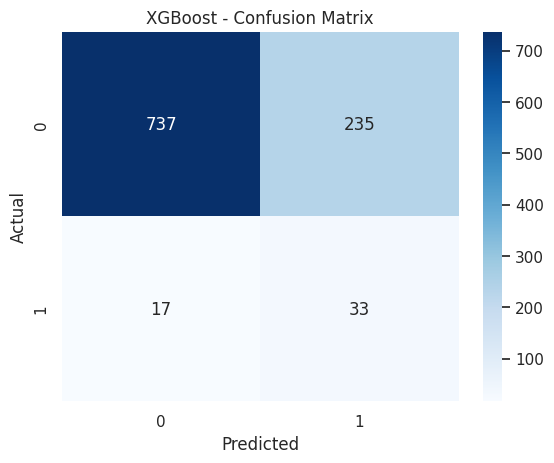

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    precision_recall_curve
)

# -----------------------
# Evaluation with Threshold
# -----------------------
def evaluate_model_with_threshold(model, X_test, y_test, model_name, threshold=0.5):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    print(f"\n--- {model_name} (Threshold = {threshold}) ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# -----------------------
# Find Best Threshold by Maximizing F1
# -----------------------
def find_best_threshold(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    print(f"Best Threshold = {best_threshold:.2f} (F1 = {f1_scores[best_idx]:.2f})")
    return best_threshold

# -----------------------
# Train and Evaluate
# -----------------------
# Random Forest with class_weight='balanced'
rf_model = RandomForestClassifier(random_state=12, class_weight='balanced')
rf_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])

best_threshold_rf = find_best_threshold(rf_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'])
evaluate_model_with_threshold(rf_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "Random Forest", best_threshold_rf)

# XGBoost (note: no class_weight param)
xgb_model = XGBClassifier(random_state=12, eval_metric='logloss', verbosity=0)
xgb_model.fit(data_after_preprocessing['modified_balanced_training_features'], data_after_preprocessing['modified_balanced_lables'])

best_threshold_xgb = find_best_threshold(xgb_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'])
evaluate_model_with_threshold(xgb_model, data_after_preprocessing['original_test_features'], data_after_preprocessing['labels_test'], "XGBoost", best_threshold_xgb)
